In [1]:
# !git clone https://github.com/tordjx/ummt.git
# import os 
# os.chdir("ummt/Core model files")
# os.getcwd()
!pip install matplotlib --quiet
!pip install livelossplot --quiet
!pip install nltk --quiet
!pip install torchtext --quiet
!pip install torchmetrics --quiet
#mc cp s3/tordjx ummt/Core*model*files --recursive
# watch -n 0.5 nvidia-smi
import nltk
nltk.download('wordnet')
image_bool = True
load_model = False


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#%%
from Modele_decodeur_maison import *
from Pipeline import *
from Trainer import * 
from greedy_beam_search import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 256

# Texts
tokenized_fr,tokenized_en, vocab_fr,vocab_en = get_train_data_nouveau(batch_size,True)
tokenized_val_fr,tokenized_val_en, _,_ = get_train_data_nouveau(batch_size,False)
#Data non batchés
n_token_fr = len(vocab_fr.keys())
n_token_en = len(vocab_en.keys())

inv_map_en = {v: k for k, v in vocab_en.items()}
inv_map_fr = {v: k for k, v in vocab_fr.items()}

n_head =8
num_encoder_layers = 4
num_decoder_layers = 4
dim_feedforward = 512
dropout = 0.1
activation = nn.Softmax(dim=2)
embedding_dim = 128

model_fr = Modèle(n_token_fr,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_fr["TOKEN_VIDE"],vocab_fr["DEBUT_DE_PHRASE"],vocab_fr["FIN_DE_PHRASE"],False,'').to(device)
model_en = Modèle(n_token_en,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_en["TOKEN_VIDE"],vocab_en["DEBUT_DE_PHRASE"],vocab_en["FIN_DE_PHRASE"],False,'').to(device)
model_fr.feedforward= model_en.feedforward
for i in range(3):
  model_fr.decoder.layers[i]= model_en.decoder.layers[i]
  model_fr.encoder.layers[i]= model_en.encoder.layers[i]
prefix = "FalseFalse"
if load_model : 
    model_en.load_state_dict(torch.load("tordjx/"+prefix+"_en"))
    model_fr.load_state_dict(torch.load("tordjx/"+prefix+"_fr"))
else : 
    with open("logs.txt",'w') as logs :
        logs.write("")
        logs.close()
if image_bool :
    train_features  = np.load("tordjx/train-resnet50-res4frelu.npy")
    val_features = np.load("tordjx/val-resnet50-res4frelu.npy")
    train_features = torch.from_numpy(train_features)
    val_features = torch.from_numpy(val_features)
    train_data_fr = [tokenized_fr, train_features]
    train_data_en = [tokenized_en, train_features]
    val_data_fr = [tokenized_val_fr, val_features]
    val_data_en = [tokenized_val_en, val_features]
def save_model(model_en,model_fr,prefix):
    torch.save(model_fr.state_dict(), "tordjx/"+prefix+"_fr")
    torch.save(model_en.state_dict(), "tordjx/"+prefix+"_en")
    import os
    import s3fs
    !pip install pandas
    import pandas
    # Create filesystem object
    S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
    fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})
    fs.upload("tordjx/"+prefix+"_fr","tordjx/"+prefix+"_fr")
    fs.upload("tordjx/"+prefix+"_en","tordjx/"+prefix+"_en")

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


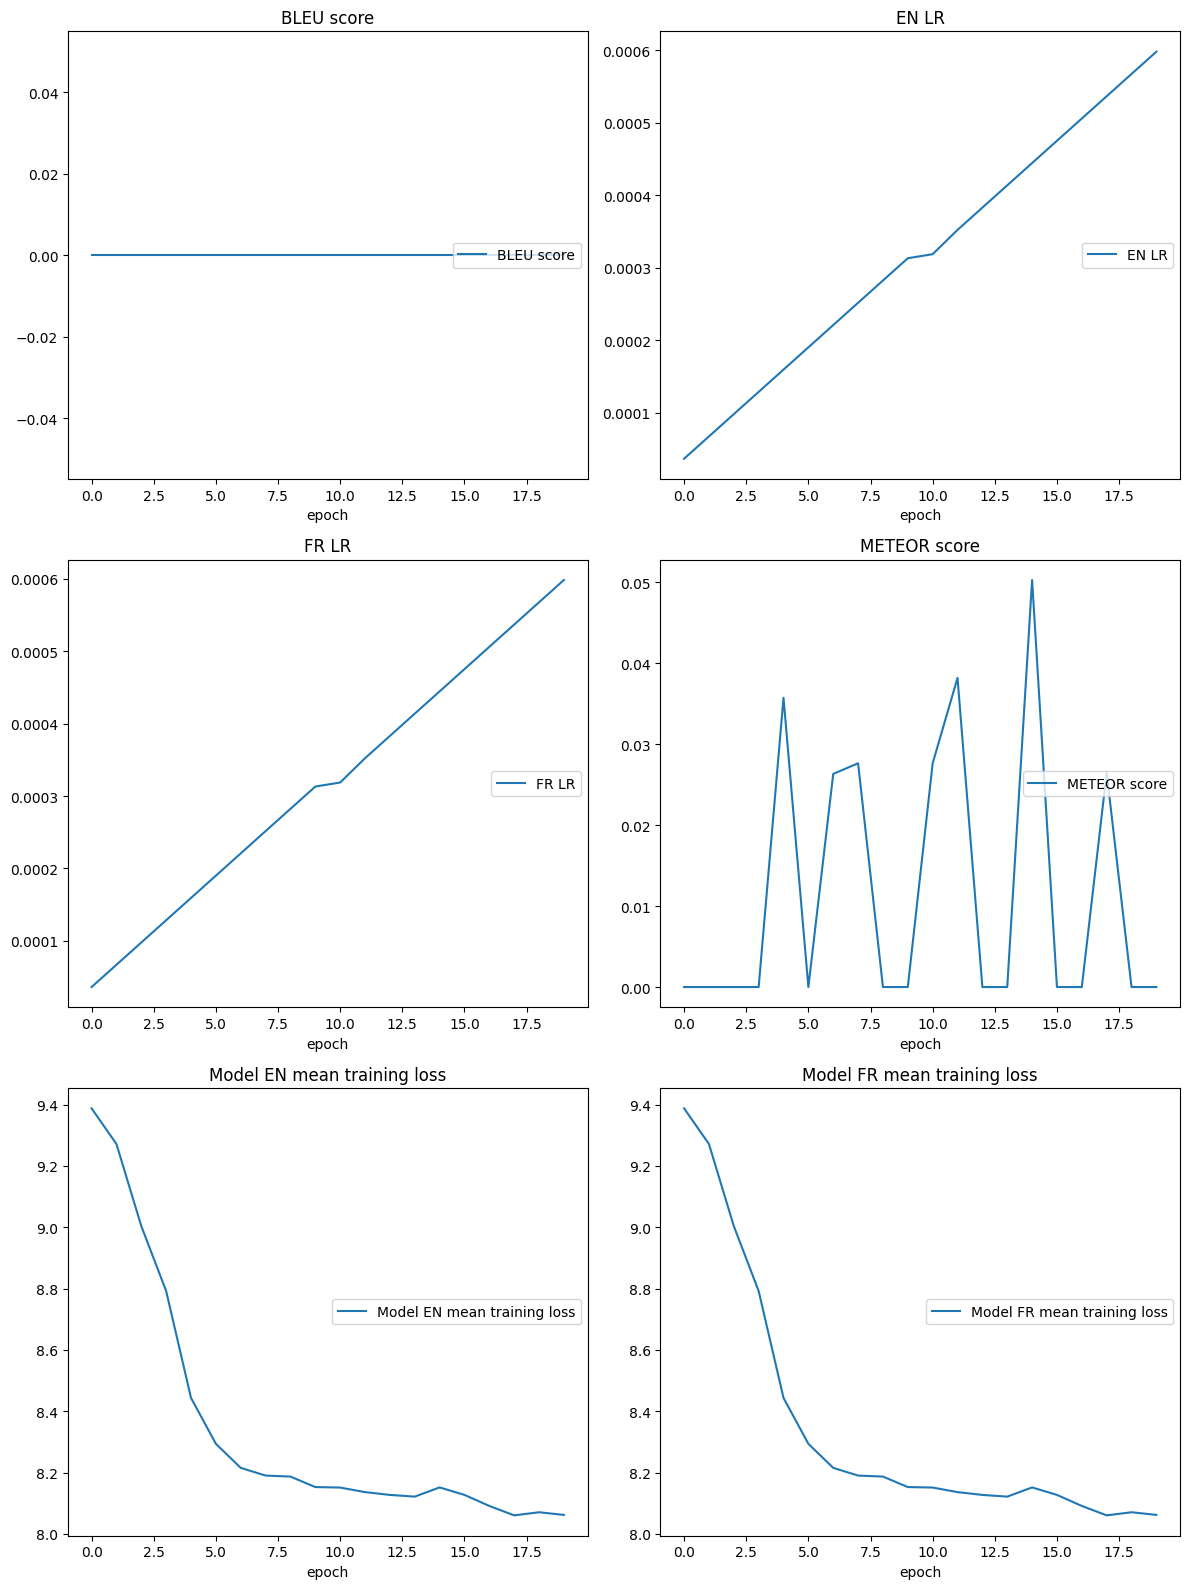

BLEU score
	BLEU score       	 (min:    0.000, max:    0.000, cur:    0.000)
EN LR
	EN LR            	 (min:    0.000, max:    0.001, cur:    0.001)
FR LR
	FR LR            	 (min:    0.000, max:    0.001, cur:    0.001)
METEOR score
	METEOR score     	 (min:    0.000, max:    0.050, cur:    0.000)
Model EN mean training loss
	Model EN mean training loss 	 (min:    8.060, max:    9.388, cur:    8.062)
Model FR mean training loss
	Model FR mean training loss 	 (min:    8.060, max:    9.388, cur:    8.062)


In [ ]:
#On va entrainer 4 modeles : avec/sans images, avec/sans teacher forcing
teacher_forcing = False
bools = [True]
for image_bool in bools : 
    print(image_bool)
    prefix = str(image_bool)+str(teacher_forcing)
    model_fr = Modèle(n_token_fr,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_fr["TOKEN_VIDE"],vocab_fr["DEBUT_DE_PHRASE"],vocab_fr["FIN_DE_PHRASE"],teacher_forcing,prefix).to(device)
    model_en = Modèle(n_token_en,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_en["TOKEN_VIDE"],vocab_en["DEBUT_DE_PHRASE"],vocab_en["FIN_DE_PHRASE"],teacher_forcing,prefix).to(device)
    model_fr.feedforward= model_en.feedforward
    for i in range(3):
        model_fr.decoder.layers[i]= model_en.decoder.layers[i]
        model_fr.encoder.layers[i]= model_en.encoder.layers[i]
    with open(prefix+"logs.txt",'w') as logs :
        logs.write("")
        logs.close()
    if image_bool :
        mixed_train(val_data_en,val_data_fr,inv_map_en,inv_map_fr,model_fr,model_en,train_data_fr,train_data_en,30,batch_size, True,1/2)
    else :
        mixed_train(tokenized_val_en,tokenized_val_fr,inv_map_en,inv_map_fr,model_fr,model_en,tokenized_fr,tokenized_en,30,batch_size, False,1/2)
    torch.save(model_fr.state_dict(), "tordjx/"+prefix+"_fr")
    torch.save(model_en.state_dict(), "tordjx/"+prefix+"_en")
    pd.DataFrame(model_en.loss_list).to_csv("tordjx/"+prefix+"loss_en.csv")
    pd.DataFrame(model_fr.loss_list).to_csv("tordjx/"+prefix+"loss_fr.csv")
    

In [ ]:
from torchvision import models, transforms
from torchvision import models, transforms
from PIL import Image

import os
def open_image(path):
    image = Image.open(path)
    image = transforms.ToTensor()(image)
    return image
from torchvision.models.feature_extraction import create_feature_extractor
with open('Images ummt/captions.txt','r') as file : 
    lines = file.readlines()
    file.close()
import os
def get_resnet_features_from_image(image):
    return_nodes = {'layer3':"layer3"}
    resnet=models.resnet152().eval()
    cropped_resnet= create_feature_extractor(resnet, return_nodes=return_nodes)
    return cropped_resnet(image)['layer3']


lines = [line[:-1].split(',') for line in  lines]
images= [line[0] for line in lines]
captions = [line[1][1:] for line in lines]
folder =["blurred","contrast","cropped","negative","noisy","raw","rotated","wrong"]
text=[]
titres = []
features=[]
paths = []

for name in folder :
    text+=captions
    titres+=[name+"_"+ image for image in images]
    for image in images: 
        paths.append('Images ummt/'+name+'/'+image)
        # if features == []:
        #     features = get_resnet_features_from_image(open_image('Images ummt/'+name+'/'+image).unsqueeze(0))
        # else : 
        #     features = torch.cat((features,get_resnet_features_from_image(open_image('Images ummt/'+name+'/'+image).unsqueeze(0))))

features = torch.load('features_test')
# features = features.to(device)
# print(features.shape)
# features = features.view(-1,1024,196).transpose(-1,-2)
# torch.save(features,"features_test")
text = [["DEBUT_DE_PHRASE"]+ligne.strip().split(" ")+["FIN_DE_PHRASE"] for ligne in text ]
longueur_max = 64
text = [[phrase[i] if i < len(phrase) else "TOKEN_VIDE" for i in range (longueur_max)] for phrase in text]
text = torch.tensor([[vocab_en[mot] for mot in phrase] for phrase in text]).to(device = device, dtype = torch.long)
text = torch.cat((text, torch.zeros(batch_size-text.shape[0],text.shape[1]).to(device = device, dtype = torch.long)))
features = torch.cat((features,torch.zeros(batch_size-features.shape[0],features.shape[1],features.shape[2]).to(device = device, dtype = torch.float)))
def plot_attention_text(phrase, trad,attention_text,titre):
    fig, ax = plt.subplots(1,1)
    attention_text = attention_text[:len(phrase)][:len(phrase)]
    attention_text = attention_text.cpu().detach().numpy()
    plt.imshow(attention_text,cmap = "inferno")
    ax.set_xticks([i for i in range(len(trad))])
    ax.set_xticklabels(trad,rotation = 90)
    ax.set_yticks([i for i in range(len(phrase))])
    ax.set_yticklabels(phrase)
    plt.colorbar()
    plt.savefig("Graphs attention/"+titre+"attention_text.png")
def plot_attention_on_image(path,attention,titre,phrase):
    for i in range (len(phrase)):
        # plt.reset_ticks()
        mot = phrase[i]
        attention_mot= attention[i]
        attention_mot = repeater(attention_mot) 
        image= open_image(path)
        image = image.cpu().detach().numpy()
        image = image.transpose(1,2,0)
        plt.imshow(image)
        plt.imshow(attention_mot,alpha = 0.3,cmap = "inferno")
        plt.colorbar()
        plt.title(mot)
        plt.savefig("Graphs attention/"+titre +mot+"attention_image.png")
        plt.show()
from PIL import Image
import os
def open_image(path):
    # print(path)
    image = Image.open(path)
    image = transforms.ToTensor()(image)
    return image
def graphiques_attention(model_fr,model_en,batched_data_en,inv_map_en,inv_map_fr,batch_size,images,titres,paths) :
    model_fr.eval()
    model_en.eval()

    src,features = batched_data_en


    src,features = src.to(device),features.to(device)

    traduction,attention_e,attention_i= CCF_greedy(model_en,model_fr,src,features,True,True)
    traduction = torch.argmax(traduction ,dim = 2)
    # for i in range(traduction.shape[0]):
    for i in range(1):#Je commente ici pour pas avoir beaucoup trop de graphiques
        #Attention text
        phrase  = cut_list_at_value([inv_map_en[src[i][j].item()] for j in range(src.shape[1])] ,"FIN_DE_PHRASE")
        phrase = [x for x in phrase if x not in ["TOKEN_VIDE","DEBUT_DE_PHRASE","FIN_DE_PHRASE"]]
        attention_i = attention_i.view(256,-1,14,14)
        # print(attention_e.shape,attention_i.shape)
        trad = cut_list_at_value([inv_map_fr[x.item()] for x in traduction[i]],'FIN_DE_PHRASE')
        trad = [x for x in trad if x not in ["TOKEN_VIDE","DEBUT_DE_PHRASE","FIN_DE_PHRASE"]]
        plot_attention_text(phrase,trad,attention_e[i],titres[i])
        #Attention image
        plot_attention_on_image(paths[i],attention_i[i],titres[i],phrase)

graphiques_attention(model_fr,model_en,[text,features],inv_map_en,inv_map_fr,batch_size,images,titres,paths)

In [ ]:
# if image_bool :
#     loss_list = learning_rate_finder(val_data_en,val_data_fr,inv_map_en,inv_map_fr,model_fr,model_en,train_data_fr,train_data_en,150,batch_size, True,1/2)
# else :
#     loss_list = learning_rate_finder(tokenized_val_en,tokenized_val_fr,inv_map_en,inv_map_fr,model_fr,model_en,tokenized_fr,tokenized_en,150,batch_size, False,1/2)

lrs = [10**(-10)*3**n for n in range(len(loss_list))]
cut = 11
begin = 10
plt.plot(lrs[begin:-cut],loss_list[begin:-cut])
plt.xscale('log')
plt.show()

In [ ]:
def moving_average(a, n=1,tail = 0) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    
    return (ret[n - 1:] / n)[tail:]

plt.plot(moving_average(model_fr.loss_list))
plt.plot(moving_average(model_en.loss_list))
print(len(model_fr.loss_list)/(29000/batch_size))


In [ ]:
from torchvision import models, transforms
from PIL import Image

import os
def open_image(path):
    image = Image.open(path)
    image = transforms.ToTensor()(image)
    return image
def image_noiser(image):
    image = image.to(device) + torch.randn(image.shape).to(device)*0.1
    return image
def save_image(image,path):
    image = image.cpu()
    image = image.detach().numpy()
    image = image.transpose(1,2,0)
    image = (image*255).astype(np.uint8)
    image = Image.fromarray(image)
    image.save(path)
    return image
def get_all_images_from_folder(path):
    images = []
    folder = [filename for filename  in os.listdir(path) if filename not in ['.amlignore', '.amlignore.amltmp']]
       
    for filename in folder:
        images.append(filename)

    return images
#Noisy
for images in get_all_images_from_folder("Images ummt/raw/"):
    save_image(image_noiser(open_image("Images ummt/raw/"+images)),"Images ummt/noisy/"+images)
#Wrong
folder = get_all_images_from_folder("Images ummt/raw/")
for i in range(len(folder)):
    save_image(open_image("Images ummt/raw/"+folder[i]),"Images ummt/wrong/"+folder[(i+1)%len(folder)])
#Blur
!pip install opencv-python
import cv2
def blur_image(image):
    image = image.cpu()
    image = image.detach().numpy()
    image = image.transpose(1,2,0)
    image = (image*255).astype(np.uint8)
    image = cv2.blur(image,(5,5))
    image = Image.fromarray(image)
    image = transforms.ToTensor()(image)
    return image
for images in get_all_images_from_folder("Images ummt/raw/"):
    save_image(blur_image(open_image("Images ummt/raw/"+images)),"Images ummt/blurred/"+images)
#Negative
def negative_image(image):
    image = image.cpu()
    image = image.detach().numpy()
    image = image.transpose(1,2,0)
    image = (image*255).astype(np.uint8)
    image = 255-image
    image = Image.fromarray(image)
    image = transforms.ToTensor()(image)
    return image
for images in get_all_images_from_folder("Images ummt/raw/"):   
    save_image(negative_image(open_image("Images ummt/raw/"+images)),"Images ummt/negative/"+images)
#Rotation
def rotate_image(image):
    image = image.cpu()
    image = image.detach().numpy()
    image = image.transpose(1,2,0)
    image = (image*255).astype(np.uint8)
    image = cv2.rotate(image,cv2.ROTATE_90_CLOCKWISE)
    image = Image.fromarray(image)
    image = transforms.ToTensor()(image)
    return image
for images in get_all_images_from_folder("Images ummt/raw/"):
    save_image(rotate_image(open_image("Images ummt/raw/"+images)),"Images ummt/rotated/"+images)
#Contrast
def contrast_image(image):
    image = image.cpu()
    image = image.detach().numpy()
    image = image.transpose(1,2,0)
    image = (image*255).astype(np.uint8)
    # image = cv2.equalizeHist(image)
    image= cv2.convertScaleAbs(image, 10, 2)

    image = Image.fromarray(image)
    image = transforms.ToTensor()(image)
    return image
for images in get_all_images_from_folder("Images ummt/raw/"):
    save_image(contrast_image(open_image("Images ummt/raw/"+images)),"Images ummt/contrast/"+images)


In [ ]:
import torch
from torchvision.models import resnet152
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.detection.mask_rcnn import MaskRCNN
from torchvision.models.detection.backbone_utils import LastLevelMaxPool
from torchvision.ops.feature_pyramid_network import FeaturePyramidNetwork

from torchvision import models, transforms
from PIL import Image
import os
def open_image(path):
    image = Image.open(path)
    image = transforms.ToTensor()(image)
    return image

return_nodes = {'layer3':"layer3"}
resnet=resnet152().eval().to(device)
cropped_resnet= create_feature_extractor(resnet, return_nodes=return_nodes)
cropped_resnet(torch.rand(1,3,210,210).to(device))['layer3'].shape